## Implement FasterRCNN from scratch

In this assignment, you will create a dataset class for Vehicles-OpenImage dataset and implement Faster R-CNN from scratch.

##Dataset:
You will use the Vehicles-OpenImages Dataset, consisting of 627 images 416x416. Dataset can be downloaded from

https://public.roboflow.com/object-detection/vehicles-openimages/1

##Tasks:

1. Create a dataset class for the above dataset
2. Implement/Use a Backbone Network (you are allowed to use a pretrained CNN i.e., ResNet, VGG)
3. Implement Region Proposal Network (RPN)
4. Implement RoI Pooling
5. Implement the training loop for Faster R-CNN
6. Evaluate the model on the test set

#Import

In [2]:
from IPython.display import clear_output

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VwbuDTnQx4AhvBx6UbFg")
project = rf.workspace("roboflow-gw7yv").project("vehicles-openimages")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [150]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor  # Import Compose
import torch
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops import box_iou
from torchvision.models import vgg16, VGG16_Weights
from torchvision.ops import boxes as box_ops
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.rpn import AnchorGenerator, RegionProposalNetwork
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.ops import nms
import torch.optim as optim
from torchvision.ops import roi_pool, nms, MultiScaleRoIAlign
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models.detection.rpn import RegionProposalNetwork, AnchorGenerator
from torchvision.models._utils import IntermediateLayerGetter
from my_utils import collate_fn

ModuleNotFoundError: No module named 'my_utils'

In [ ]:
!pip install --upgrade torchvision

#1.Create a dataset class

1- loads the dataset annotations

2- maps image IDs to their corresponding annotations,

3- returns the images and their targets (bounding boxes and labels) when an item is accessed.

In [95]:
class COCODataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms if transforms else Compose([ToTensor()]) # transformations apply to the images.
        with open(annotation_file) as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']
        self.categories = {cat['id']: cat['name'] for cat in self.coco['categories']}

        # Create a dictionary to map image_id to annotations - all annotations associated with a specific image
        self.image_id_to_annotations = {}
        for annotation in self.annotations:
            image_id = annotation['image_id']
            if image_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[image_id] = []
            self.image_id_to_annotations[image_id].append(annotation)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): #  format that can be used for training
      img_info = self.images[idx]
      img_path = os.path.join(self.root, img_info['file_name'])
      img = Image.open(img_path).convert("RGB")

      annotations = self.image_id_to_annotations[img_info['id']]

      boxes = []
      labels = []
      for annotation in annotations: # calculate the bounding box coordinates from the annotation data.
        xmin = annotation['bbox'][0]
        ymin = annotation['bbox'][1]
        xmax = xmin + annotation['bbox'][2]
        ymax = ymin + annotation['bbox'][3]
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(annotation['category_id'])

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.as_tensor(labels, dtype=torch.int64)

      target = {}
      target['boxes'] = boxes
      target['labels'] = labels

      # Apply the transforms to the image
      if self.transforms:
            img = self.transforms(img)  # Pass a tuple to transforms


      return img, target

- the bounding boxes will be resized along with the images, ensuring that the annotations accurately match the resized images.

In [64]:
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import functional as F
'''


class ResizeBoundingBoxes(object):
    def __init__(self, size):
        self.size = size
        self.resize_transform = Resize(size)


    def __call__(self, sample):
        image, target = sample  # Unpack the sample tuple
        image = F.resize(image, self.size)

        # Resize the bounding boxes
        if 'boxes' in target:
            boxes = target['boxes']
            # Calculate scaling factors
            width_scale = self.size[0] / image.width
            height_scale = self.size[1] / image.height

            # Apply scaling to bounding boxes
            boxes[:, 0] *= width_scale  # x_min
            boxes[:, 1] *= height_scale  # y_min
            boxes[:, 2] *= width_scale  # x_max
            boxes[:, 3] *= height_scale  # y_max

            target['boxes'] = boxes


        return image, target

- The collate_fn : helper function used to collate the samples in a batch.

In [146]:
def collate_fn(batch):
    return tuple(zip(*batch))

## Create dataset and dataloaders


In [111]:
# applies a transformations to the images.
from torchvision.transforms import Compose, Resize, ToTensor

transforms = Compose([
    Resize((256, 256)),  # Resize to reduce memory usage
    ToTensor()
])

In [86]:
'''
!pip install albumentations

from torchvision.transforms import Compose, ToTensor
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [87]:
'''
# Define the transformations
transforms = A.Compose([
    A.Resize(256, 256),  # Resize the image
    A.Normalize(),  # Normalize the image (optional, but recommended)
    ToTensorV2()  # Convert to PyTorch tensor
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

In [133]:
train_dataset = COCODataset(root='/content/Vehicles-OpenImages-1/train', annotation_file='/content/Vehicles-OpenImages-1/train/_annotations.coco.json', transforms=transforms)
val_dataset = COCODataset(root='/content/Vehicles-OpenImages-1/valid', annotation_file='/content/Vehicles-OpenImages-1/valid/_annotations.coco.json', transforms=transforms)
test_dataset = COCODataset(root='/content/Vehicles-OpenImages-1/test', annotation_file='/content/Vehicles-OpenImages-1/test/_annotations.coco.json', transforms=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [40]:
type(train_dataset)

__main__.COCODataset

In [50]:
print("Number of images:", len(train_dataset))
print("Number of annotations:", len(train_dataset.annotations))
print("Number of categories:", len(train_dataset.categories))
print("Number of images in the validation set:", len(val_dataset))
print("Number of images in the test set:", len(test_dataset))

Number of images: 878
Number of annotations: 1676
Number of categories: 6
Number of images in the validation set: 250
Number of images in the test set: 126


In [113]:
for images, targets in train_dataloader:
    img = images[0]  # Get the first image in the batch
    target = targets[0]  # Get the corresponding target
    break  # Exit the loop after getting one image

print("Image shape:", img.shape)
print("Target:", target)

Image shape: torch.Size([3, 256, 256])
Target: {'boxes': tensor([[215., 142., 390., 375.]]), 'labels': tensor([5])}


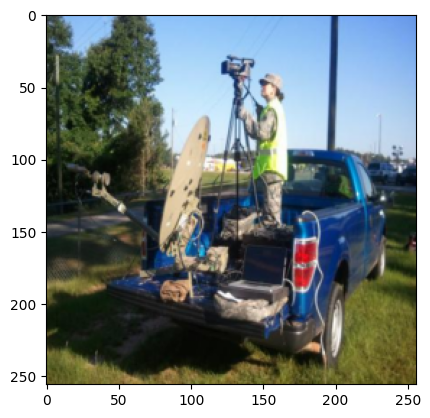

In [114]:
import matplotlib.pyplot as plt

# Assuming 'img' is a PyTorch tensor in the shape (C, H, W)
img = img.permute(1, 2, 0)  # Permute to (H, W, C) for matplotlib

plt.imshow(img)
plt.show()


#2.Backbone Network and RPN and Anchor Generator

- The IntermediateLayerGetter module is used to extract features from a specific layer of the backbone network ('layer4').

- no need for the fully connected layers, which are typically used for image classification tasks.

- The purpose of the AnchorGenerator is to define a set of anchor boxes , used by the RPN , starting point for the RPN to predict the bounding boxes of the objects in the image.

- Freeze : prevent the backbone network from being updated during trainin

In [15]:
"""
# Load a pretrained CNN model (e.g., ResNet-50)
backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Remove the fully connected layers
feature_extractor = IntermediateLayerGetter(backbone, return_layers={'layer4': 'layer4'}) # Change the return layer to 'layer4'

# Get the last layer of the backbone network
last_layer = feature_extractor['layer4']

# Get the number of output channels from the last layer
in_channels = last_layer[-1].conv3.out_channels # Access the 'out_channels' attribute from the last convolutional layer

# Create the Anchor Generator
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Create the Region Proposal Network (RPN)
# Pass in_channels to the AnchorGenerator instead of RegionProposalNetwork

rpn = RegionProposalNetwork(
    anchor_generator=anchor_generator,
    head=None,  # No head for RPN
    fg_iou_thresh=0.7,
    bg_iou_thresh=0.3,
    batch_size_per_image=256,
    positive_fraction=0.5,
    pre_nms_top_n=2000,
    post_nms_top_n=1000,
    nms_thresh=0.7,
    score_thresh=0.0
)

# Freeze the backbone network
for param in backbone.parameters():
    param.requires_grad = False

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
rpn.to(device)
"""

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
)

##RPN loss


In [18]:
# Define the loss functions
# Classification loss (binary cross-entropy)
cls_loss_fn = nn.BCELoss()

# Regression loss (smooth L1 loss)
reg_loss_fn = nn.SmoothL1Loss()

def rpn_loss(cls_logits, bbox_deltas, labels, bbox_targets):
    """
    Calculate the RPN loss.

    Args:
        cls_logits (torch.Tensor): Classification logits for each anchor.
        bbox_deltas (torch.Tensor): Bounding box regression deltas for each anchor.
        labels (torch.Tensor): Ground truth labels (0 for background, 1 for object).
        bbox_targets (torch.Tensor): Ground truth bounding box coordinates.

    Returns:
        torch.Tensor: The total RPN loss.
    """
    # Calculate the classification loss
    cls_loss = cls_loss_fn(cls_logits, labels)

    # Calculate the regression loss
    reg_loss = reg_loss_fn(bbox_deltas, bbox_targets)

    # Calculate the total RPN loss
    total_loss = cls_loss + reg_loss

    return total_loss

#3.RoI Pooling

- MultiScaleRoIAlign module:
 used to extract features from multiple feature maps, which can help the model capture information at different scales.

In [16]:
# Create the MultiScaleRoIAlign module

'''

roi_align = MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roi_align.to(device)

MultiScaleRoIAlign(featmap_names=['0'], output_size=(7, 7), sampling_ratio=2)

#4.FasterRCNNModel

- Faster R-CNN is a popular object detection model that combines a region proposal network (RPN) with a detection network to efficiently detect objects in an image.

- The backbone is responsible for extracting visual features from the input image.

-  (RoI) pooling on the feature maps at multiple scales to extract a fixed-size feature representation for each proposed region.

- The anchor generator is responsible for generating anchor boxes at different scales and aspect ratios

- RPN head predicts the objectness score and bounding box regression for each anchor.

In [142]:

from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor, RPNHead, AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNet18_Weights # Updated import


class FasterRCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(FasterRCNNModel, self).__init__()
        # Load the pre-trained backbone (e.g., ResNet-18)
        backbone = models.resnet18()



        # Remove the fully connected layers
        feature_extractor = IntermediateLayerGetter(backbone, return_layers={'layer4': '0'})


        # Get the last layer of the backbone network or Conv
        last_layer = feature_extractor['layer4']

        # Get the number of output channels from the last layer
        in_channels = last_layer[-1].conv2.out_channels

        # Define the Region Proposal Network (RPN)
        anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                           aspect_ratios=((0.5, 1.0, 2.0),))
        # Add the MultiScaleRoIAlign module
        roi_align = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        # Define the RPN head
        rpn_head = RPNHead(in_channels, anchor_generator.num_anchors_per_location()[0])
        backbone.out_channels = in_channels

        # Define the Faster R-CNN model
        self.model = FasterRCNN(backbone, num_classes=num_classes, rpn_head=rpn_head,
                               anchor_generator=anchor_generator,box_roi_pool=roi_align)

    def forward(self, x,target=None):
        return self.model(x, targets=targets)

In [ ]:
# Define the training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FasterRCNNModel(num_classes=91)
train_dataset = COCODataset(root='/content/Vehicles-OpenImages-1/train', annotation_file='/content/Vehicles-OpenImages-1/train/_annotations.coco.json', transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)

# Move model to device after it's created
# If still out of memory try reducing the batch size of the dataloader.
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

num_epochs = 10
gradient_accumulation_steps = 2  # Accumulate gradients over 2 batches

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()
    for i, (images, targets) in enumerate(train_dataloader):
        # Move images and targets to device in smaller batches if necessary
        # Try moving images and targets to device in the loop to reduce peak memory usage
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.cuda.amp.autocast():  # Enable mixed precision
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Scale the loss and accumulate gradients
        scaler.scale(losses).backward()

        if (i + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += losses.item()

        # Use torch.cuda.empty_cache() to clear unused GPU memory
        torch.cuda.empty_cache()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_dataloader):.4f}')

# Save the trained model
torch.save(model.state_dict(), 'faster_rcnn_model.pth')